In [1]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

from tqdm import tqdm
import dill
import sys

In [2]:
# Import the environment and plotting functions
sys.path.insert(0,'./env')
sys.path.insert(0,'./utils')
from env.food_collector import Food_Collector_Env
from utils.plot_results import plot_scores_epsilon

# Independent Q-learning

## Define QL agent

In [3]:
class QLearningAgent():

    def __init__(self, num_actions, num_states, eps_start=1.0, eps_decay=.9999, eps_min=1e-08, step_size=0.1, gamma=1):
        # Initialise agent
        self.num_actions = num_actions
        self.num_states = num_states
        self.epsilon = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.step_size = step_size
        self.gamma = gamma
        self.rand_generator = np.random.RandomState(1)
        
        # Create an array for action-value estimates and initialize it to zero.
        self.state_dict = {}
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, state):

        #Update epsilon at the start of each episode
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)


        #Add state to dict if new + get index of state
        ############################
        # YOUR IMPLEMENTATION HERE #
        ###########################
        state_tuple = tuple(state)
        if state_tuple not in self.state_dict:
            self.state_dict[state_tuple] = len(self.state_dict)

        # Choose action using epsilon greedy.
        ############################
        # YOUR IMPLEMENTATION HERE #
        ############################
        current_state_idx = self.state_dict[state_tuple]
        if self.rand_generator.random() < self.epsilon:
            # Explore: select a random action
            action = self.rand_generator.randint(self.num_actions)
        else:
            # Exploit: select the action with the highest value
            action = self.argmax(self.q[current_state_idx])



        self.prev_state_idx = self.state_dict[state]
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):

        #Add state to dict if new + get index of state
        ############################
        # YOUR IMPLEMENTATION HERE #
        ############################
        state_tuple = tuple(state)
        if state_tuple not in self.state_dict:
            self.state_dict[state_tuple] = len(self.state_dict)
        current_state_idx = self.state_dict[state_tuple]
        # Choose action using epsilon greedy.
        ############################
        # YOUR IMPLEMENTATION HERE #
        ############################
        if self.rand_generator.random() < self.epsilon:
        # Explore: select a random action
            action = self.rand_generator.randint(self.num_actions)
        else:
            # Exploit: select the action with the highest value
            action = self.argmax(self.q[current_state_idx])

        # Update q values
        # self.q[self.prev_state_idx][self.prev_action] =  ######## YOUR IMPLEMENTATION HERE ########
        # Q(s,a) = Q(s,a) + alpha * [r + gamma * max_a' Q(s',a') - Q(s,a)]
            self.q[self.prev_state_idx][self.prev_action] = (
                self.q[self.prev_state_idx][self.prev_action] + 
                self.step_size * (reward + self.gamma * np.max(self.q[current_state_idx]) - 
                                self.q[self.prev_state_idx][self.prev_action])
            )
            
        self.prev_state_idx = self.state_dict[state]
        self.prev_action = action
        return action
    

    def agent_end(self, state, reward):
        #Add state to dict if new + get index
        ############################
        # YOUR IMPLEMENTATION HERE #
        ############################
        state_tuple = tuple(state)
        if state_tuple not in self.state_dict:
            self.state_dict[state_tuple] = len(self.state_dict)
        # Perform the last q value update
        # self.q[self.prev_state_idx][self.prev_action] =  ######## YOUR IMPLEMENTATION HERE ########
        # Since this is the terminal state, there is no future reward
        # Q(s,a) = Q(s,a) + alpha * [r - Q(s,a)]
        self.q[self.prev_state_idx][self.prev_action] = (
            self.q[self.prev_state_idx][self.prev_action] + 
            self.step_size * (reward - self.q[self.prev_state_idx][self.prev_action])
        )                   


        
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

## Train independent agents

In [4]:
def train_QL_agents(n_agents, num_episodes, max_steps_done, eps_decay, eps_min, step_size, gamma):

    # initiate environment
    env = Food_Collector_Env(grid_size=[11,11], n_agents=2)

    # get numer of states and actions from environment
    n_states = 3000000
    n_actions = env.action_space[0].n
    
    # Initialise agents
    agents = []
    for _ in range(n_agents):
        QL_agent = QLearningAgent(num_actions=n_actions, num_states=n_states,
                      eps_start = 1.0, eps_decay=eps_decay, eps_min=eps_min,
                      step_size=step_size, gamma=gamma)
        agents.append(QL_agent)

    # Monitor the scores and epsilon for each episode
    episode_rewards = [ [] for _ in range(n_agents)]
    epsilon_history = list()
    won_games = 0
    
    # for episode in num_episodes
    for episode in tqdm(range(num_episodes)):
        
        rewards_temp = [ [] for _ in range(n_agents)]
        
        # get initial state and actions
        states = env.reset()
        for i in range(len(agents)):
            action = agents[i].agent_start(states[i])
        
        rewards = [0 for _ in range(n_agents)]
        steps = 0
        
        while True:
            steps += 1
            actions = []
            for i in range(n_agents):
                action = agents[i].agent_step(rewards[i], states[i])
                actions.append(action)
            
            next_states, rewards, done, info = env.step(actions)
            
            for i in range(n_agents):
                rewards_temp[i].append(rewards[i])
            
            if done[0]:
                won_games+=1
                for i in range(n_agents):
                    agents[i].agent_end(states[i], rewards[i]) #update q values last time
                
                if episode%1000==0:
                    for i in range(n_agents):
                        episode_rewards[i].append(sum(rewards_temp[i]))
                epsilon_history.append(agents[0].epsilon)
                break
            
            if steps >= max_steps_done:
                if episode%1000==0:
                    for i in range(n_agents):
                        episode_rewards[i].append(sum(rewards_temp[i]))
                epsilon_history.append(agents[0].epsilon)
                break
                
            states = next_states
    print(f'Games won: {won_games}, in percentage: {(100*won_games/num_episodes):.2f}')
    return agents, episode_rewards, epsilon_history

In [5]:
# HYPERPARAMETERS
N_AGENTS = 2
NUM_EPISODES = 600000
EPS_DECAY = 0.9999
EPS_MIN = 0.3
STEP_SIZE = 0.1
GAMMA = 0.99
MAX_STEPS_DONE = 70

In [6]:
agents, reward_history, epsilon_history = train_QL_agents(N_AGENTS, NUM_EPISODES, MAX_STEPS_DONE, EPS_DECAY,
                                                          EPS_MIN, STEP_SIZE, GAMMA)

100%|██████████| 600000/600000 [25:55<00:00, 385.79it/s]

Games won: 468045, in percentage: 78.01


In [9]:
dill.dump_session("dump")

In [ ]:
dill.load_session("dump")

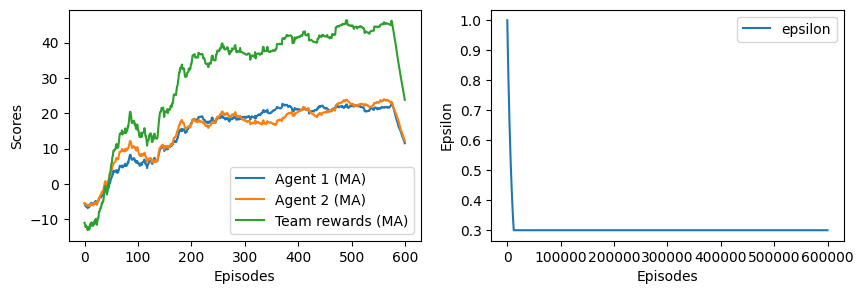

In [7]:
plot_scores_epsilon(reward_history, epsilon_history, moving_avg_window = 50)

## Save agents

In [8]:
import dill

# Save the file
dill.dump(agents[0], file = open("trained_agents/QLagent1.pickle", "wb"))
dill.dump(agents[1], file = open("trained_agents/QLagent2.pickle", "wb"))


# Load the file
# a1 = dill.load(open("trained_agents/QLagent1.pickle", "rb"))
# a2 = dill.load(open("trained_agents/QLagent2.pickle", "rb"))
# agents2 = [a1,a2]